In [4]:
import pandas as pd
import numpy as np
import cv2

from matplotlib import pyplot as plt

from scipy.spatial.transform import Rotation

import os

# Load data

## Drill 3D

In [5]:
drill_3d_points = np.load('data/drill_3d_points/power_drill_punkty_3d.npy')
drill_3d_points.shape

(9, 3)

## Camera position

In [6]:
camera_matrix = np.load('data/camera_coords/camera_matrix.npy')
camera_matrix

array([[1.066778e+03, 0.000000e+00, 3.129869e+02],
       [0.000000e+00, 1.067487e+03, 2.413109e+02],
       [0.000000e+00, 0.000000e+00, 1.000000e+00]])

## Keypoints

In [7]:
dataset_numbers = ['06', '09', '10', '11', '12', '18', '24', '30', '37', '38', '50']

def load_keypoints(dataset_numbers):
    file_start, file_end = 'data/keypoints/00', '_keypoints2d.txt'
    keypoints = [pd.read_csv(file_start+no+file_end, header=None).loc[:, 1:].values for no in dataset_numbers]
    return np.vstack(keypoints)

keypoints = load_keypoints(dataset_numbers)
keypoints = keypoints.reshape((-1, 9, 2))
keypoints = keypoints.astype('double')
keypoints.shape

(3140, 9, 2)

## Poses

In [8]:
def load_poses(dataset_numbers):
    file_start, file_end = 'data/poses/00', '_gt.npy'
    poses = [np.load(file_start+no+file_end) for no in dataset_numbers]
    return np.vstack(poses)
                         
poses = load_poses(dataset_numbers)
poses.shape

(3140, 7)

In [9]:
pose_translations = poses[:, 4:]
pose_translations.shape

(3140, 3)

In [10]:
quaternions = poses[:, :4]
rotations = Rotation.from_quat(quaternions)
pose_rotations = rotations.as_euler('xyz', degrees=True)
pose_rotations.shape

(3140, 3)

In [11]:
final_poses = np.hstack([pose_rotations, pose_translations])
final_poses.shape

(3140, 6)

# Pose estimation

In [320]:
dist_coeffs = np.zeros((4, 1))

pred_rotations = []
pred_translations = []
for i in range(final_poses.shape[0]):
    success, this_pred_rotations, this_pred_translations = cv2.solvePnP(drill_3d_points, keypoints[i], camera_matrix, dist_coeffs)
    this_pred_rotations = Rotation.from_rotvec(this_pred_rotations.reshape((-1))).as_euler("xyz", degrees=True)
    
    pred_rotations.append(this_pred_rotations)
    pred_translations.append(this_pred_translations.reshape((-1)))
    
pred_rotations = np.vstack(pred_rotations)
pred_translations = np.vstack(pred_translations)

pred_rotations.shape, pred_translations.shape

((3140, 3), (3140, 3))

In [321]:
pred_poses = np.hstack([pred_rotations, pred_translations])
pred_poses.shape

(3140, 6)

In [322]:
pred_translations

array([[-0.51656103, -0.38888407,  2.1942839 ],
       [-0.51656103, -0.38888407,  2.1942839 ],
       [-0.51687406, -0.3887129 ,  2.19318589],
       ...,
       [-0.49499386, -0.35847467,  2.09397256],
       [-0.4948819 , -0.35862344,  2.09346658],
       [-0.49448633, -0.35880721,  2.09178364]])

In [323]:
pose_translations

array([[ 0.02548364, -0.06547788,  0.91183501],
       [ 0.03066942, -0.06486887,  0.91243947],
       [ 0.02707459, -0.06187437,  0.91432244],
       ...,
       [-0.06666091,  0.0451831 ,  0.70197214],
       [-0.06662193,  0.0456748 ,  0.70153677],
       [-0.06641677,  0.04261829,  0.70023833]])

# Evaluation

In [324]:
from sklearn.metrics import mean_squared_error

rotation_error = mean_squared_error(pose_rotations, pred_rotations)
translations_error = mean_squared_error(pose_translations, pred_translations)
print(f'Rotations error: {rotation_error}, Translations error: {translations_error}')

Rotations error: 4082.843744519627, Translations error: 0.8879727992098817


# Example 1

000121-color.png


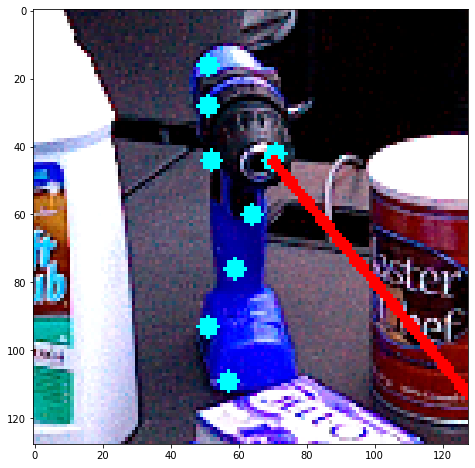

In [372]:
idx = 20

file_names = os.listdir('./data/images/0006')
file_name = file_names[idx+1]
print(file_name)

img = cv2.imread(f'data/images/0006/{file_name}')

nose_end_point2D, jacobian = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), pred_rotations[idx], pred_translations[idx], camera_matrix, dist_coeffs)

for p in keypoints[idx]:
  cv2.circle(img, (int(p[0]), int(p[1])), 3, (0,255,255), -1)

point1 = (int(keypoints[idx][0][0]), int(keypoints[idx][0][1]))
 
point2 = (int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))
 
cv2.line(img, point1, point2, (255, 0, 0), 2)

#Show the image with matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.show()

# Example 2

001501-color.png


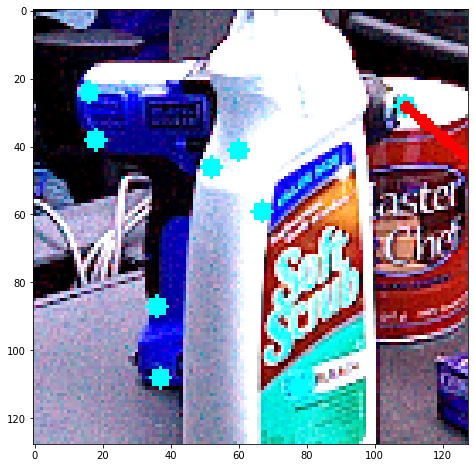

In [365]:
idx = 250

file_names = os.listdir('./data/images/0006')
file_name = file_names[idx+1]
print(file_name)

img = cv2.imread(f'data/images/0006/{file_name}')

nose_end_point2D, jacobian = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), pred_rotations[idx], pred_translations[idx], camera_matrix, dist_coeffs)

for p in keypoints[idx]:
  cv2.circle(img, (int(p[0]), int(p[1])), 3, (0,255,255), -1)

point1 = (int(keypoints[idx][0][0]), int(keypoints[idx][0][1]))
 
point2 = (int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))
 
cv2.line(img, point1, point2, (255, 0, 0), 2)

#Show the image with matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.show()